The purpose of this notebook is to find DepMap dependencies that correlate with local ancestry fractions. We have already generated and exported these local ancestry fractions in the "Genotype Phasing And RFMix" and the "Generate_DepMap_Ancestry_Figure" datasets

# First, set up the environment.

In [1]:
#Arguments/Parameters

working_dir = "/home/jupyter/notebooks/Ancestry"
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET')
out_directory = "avana14" #the output directory name

In [2]:
#Set up the environment

#load packages
library(tidyverse)
library(reshape2)
library(ggforce)
library(stringr)
library(ggrepel)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

#Make directories
system(glue::glue("
cd {working_dir}

#Create the directory to store the liftover files
if [ ! -d '{working_dir}/ccle_ancestry_analysis' ] 
then
mkdir ccle_ancestry_analysis
fi

"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




# Load and format the data

First, load in all of the data and massage it into the correct format.

In [11]:
#Download and load in the chronos data
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/CRISPR_gene_effect.csv .
"))

paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
chronos.scores = read.table('CRISPR_gene_effect.csv', sep = ",")
chronos.scores[1,] = gsub(" .*", "", chronos.scores[1,]) #Remove the trailing number after the gene symbol [e.g A1BG (1) -> A1BG]
colnames(chronos.scores) <- as.character(chronos.scores[1, ]) #Then set those back to the column names
chronos.scores <- chronos.scores[-1,] #And remove the row from the dataset. The dataset should be all set now 
chronos.scores[2:ncol(chronos.scores)] = apply(chronos.scores[,2:ncol(chronos.scores)], 2, as.numeric)

#Load in the ancestry fraction data
paste(working_dir, "/admixture", sep = "") %>% setwd()
ancestry.averages = read.table('ccle.projections.txt', sep = "\t", header = T)

In [12]:
#Merge the two datasets together 

ancestry.and.chronos = inner_join(ancestry.averages, chronos.scores)
ancestry.and.chronos[1:5, 1:10]

Joining, by = "DepMap_ID"



,EUR,EAS,AMR,SAS,AFR,DepMap_ID,lineage_subtype,A1BG,A1CF,A2M
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,0.898368,0.014906,0.025614,0.052141,0.008971,ACH-000936,ovary,-0.01064753,-0.10955915,0.002976658
2,0.915203,0.006926,0.029091,0.026713,0.022068,ACH-000290,lung,-0.16488149,-0.05276508,0.072342498
3,0.287354,0.006567,0.036589,0.013621,0.655870,ACH-000427,gastric,0.01406614,-0.01209719,0.061511063
4,0.833037,0.017105,0.040665,0.044040,0.065153,ACH-000885,ovary,-0.13671492,-0.08869176,0.077750105
5,0.000010,0.953238,0.009877,0.033380,0.003495,ACH-000607,soft_tissue,0.08401849,-0.02471432,0.093970731


In [16]:
#Define a function which calculates whether there are dependencies that are associated with ancestry

ancestry_association_test = function(data = ancestry.and.chronos, ancestry) {
    
    high.ancestry = data %>% filter(.data[[ancestry]] >= 0.5) #Extract the fraction of the data that has 'high ancestry'
    low.ancestry = data %>% filter(.data[[ancestry]] < 0.5) #Extract the fraction of the data that has 'low ancestry'
    
    gene.start = 8 #Define the start of the dependency data
    gene.end = ncol(data) #Define the end of the dependency data
    gene.names = data[,gene.start:gene.end] %>% colnames()
    
    pval.vector = NULL
    for(i in gene.start:gene.end){
        
        high.vector = high.ancestry[,i] %>% as.vector() %>% as.numeric() #Make a vector with the depenedency scores from the 'high ancestry' samples
        low.vector = low.ancestry[,i] %>% as.vector() %>% as.numeric() #Make a vector with the depenedency scores from the 'low ancestry' samples
        pvalue = t.test(high.vector, low.vector, alternative = "two.sided")$p.value #Calculate the p-value
        pval.vector = c(pval.vector, pvalue)
        
    }
    names(pval.vector) = gene.names #assign the gene names as names for the vector
    return(pval.vector) #send the results outside of the function
}

In [17]:
#Calculate the p-values for all of the ancestry associations.
afr.pvals = ancestry_association_test(ancestry = "AFR")
amr.pvals = ancestry_association_test(ancestry = "AMR")
eas.pvals = ancestry_association_test(ancestry = "EAS")
eur.pvals = ancestry_association_test(ancestry = "EUR")
sas.pvals = ancestry_association_test(ancestry = "SAS")

In [18]:
#Merge the data together and then write it
compiled.df <- cbind(names(afr.pvals), afr.pvals, amr.pvals, eas.pvals, eur.pvals, sas.pvals) %>% data.frame()
colnames(compiled.df) <- c("gene", "pval_afr", "pval_amr", "pval_eas", "pval_eur", "pval_sas")

paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
write.table(compiled.df, 'ancestry_chronos_ttest_correlations.txt', sep = "\t", row.names = F, quote = F)

# Now generate a cool qqplot with the t-test data

First, format the the dataset in the ggplot format.

In [23]:
#Format the plot in the ggplot format
compiled.df[,2:6] = apply(compiled.df[,2:6], 2, as.numeric)

#Melt and format the ggplot dataframe
melted.df.for.plotting = compiled.df %>% 
melt() %>%
arrange(value)

#Add in a column that has a random distribution of p-values
set.seed(42)
random.dist = runif(nrow(melted.df.for.plotting), min = 0, max = 1) %>%
sort(decreasing = FALSE)
melted.df.for.plotting = cbind(melted.df.for.plotting, random.dist)

Using gene as id variables



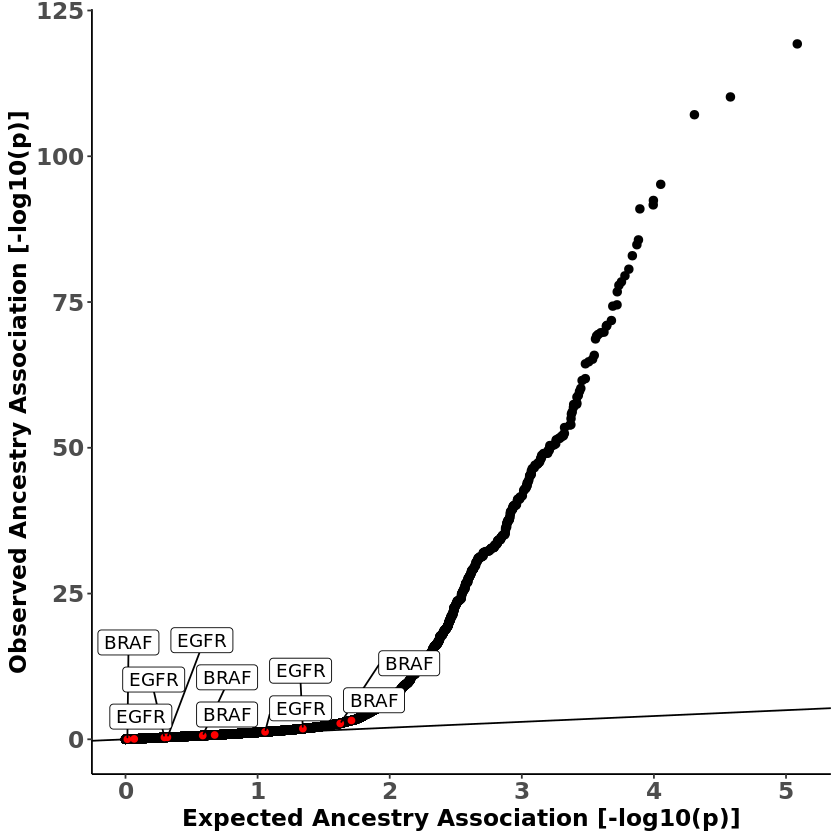

In [24]:
#Generate the qqplot
set.seed(42)

ggplot(melted.df.for.plotting, aes(x = -log10(random.dist), y = -log10(value))) +
geom_point(size = 2) +

theme_bw() +

theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +

theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) +

theme(axis.text.x = element_text(face="bold", 
                           size=14),
          axis.text.y = element_text(face="bold", 
                           size=14)) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
  ) +

geom_abline(intercept = 0, slope = 1) +

xlab("Expected Ancestry Association [-log10(p)]") +
ylab("Observed Ancestry Association [-log10(p)]") +

#scale_color_manual(values = group.colors) +

#label specific points in the ggplot
geom_point(data = melted.df.for.plotting %>% filter(gene %in% c("BRAF", "EGFR")), color = "red") +

geom_label_repel(
data = melted.df.for.plotting %>% filter(gene %in% c("BRAF", "EGFR")),
aes(-log10(random.dist), -log10(value), label = gene),
nudge_x = 0.1,
nudge_y = 5
) 



#Put the exported image into the google bucket
ggsave("ancestry_association_ttest.tiff", dpi = 300, width = 10, height = 10)
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp ancestry_association_ttest.tiff {workspace_bucket}
"))

# Perform analysis with logistic regression

In the previous analysis I used t-tests to measure the association between dependencies and ancestry groups. However, one problem is that there is a tumor type bias in this analysis since some ancestry groups are enriched in some tumor types. We need to correct for this.

To do this correction I decided to switch to using logistic regression while adjusting for tumor type as a covariate.

In [42]:
#Calculate logistic regression p-values for AFR ancestry
gene.start = 8 #Define the start of the dependency data
gene.end = ncol(ancestry.and.chronos) #Define the end of the dependency data
gene.names = ancestry.and.chronos[,gene.start:gene.end] %>% colnames()
    
afr.pval.vector = NULL
for(i in gene.start:gene.end){
#Calculate the linear model
lm.model <- lm(AFR ~ ancestry.and.chronos[,i] + lineage_subtype, data = ancestry.and.chronos) %>%
    suppressWarnings()
#Get the p-value from the glm
afr.pval.vector[i-gene.start + 1] <- coef(summary(lm.model))[2,4]
}

ERROR: Error in mblm(AFR ~ ancestry.and.chronos[, i] + lineage_subtype, data = ancestry.and.chronos): Only linear models are accepted


In [25]:
#Calculate logistic regression p-values for AMR ancestry
gene.start = 8 #Define the start of the dependency data
gene.end = ncol(ancestry.and.chronos) #Define the end of the dependency data
gene.names = ancestry.and.chronos[,gene.start:gene.end] %>% colnames()
    
amr.pval.vector = NULL
for(i in gene.start:gene.end){
   #Calculate the linear model
lm.model <- lm(AMR ~ ancestry.and.chronos[,i] + lineage_subtype, data = ancestry.and.chronos) %>%
        suppressWarnings()
#Get the p-value from the glm
amr.pval.vector[i-gene.start + 1] <- coef(summary(lm.model))[2,4]
}

In [26]:
#Calculate logistic regression p-values for EAS ancestry
gene.start = 8 #Define the start of the dependency data
gene.end = ncol(ancestry.and.chronos) #Define the end of the dependency data
gene.names = ancestry.and.chronos[,gene.start:gene.end] %>% colnames()
    
eas.pval.vector = NULL
for(i in gene.start:gene.end){
   #Calculate the linear model
lm.model <- lm(EAS ~ ancestry.and.chronos[,i] + lineage_subtype, data = ancestry.and.chronos) %>%
        suppressWarnings()
#Get the p-value from the glm
eas.pval.vector[i-gene.start + 1] <- coef(summary(lm.model))[2,4]
}

In [27]:
#Calculate logistic regression p-values for EUR ancestry
gene.start = 8 #Define the start of the dependency data
gene.end = ncol(ancestry.and.chronos) #Define the end of the dependency data
gene.names = ancestry.and.chronos[,gene.start:gene.end] %>% colnames()
    
eur.pval.vector = NULL
for(i in gene.start:gene.end){
   #Calculate the linear model
lm.model <- lm(EUR ~ ancestry.and.chronos[,i] + lineage_subtype, data = ancestry.and.chronos) %>%
    suppressWarnings()
#Get the p-value from the glm
eur.pval.vector[i-gene.start + 1] <- coef(summary(lm.model))[2,4]
}

In [28]:
#Calculate logistic regression p-values for SAS ancestry
gene.start = 8 #Define the start of the dependency data
gene.end = ncol(ancestry.and.chronos) #Define the end of the dependency data
gene.names = ancestry.and.chronos[,gene.start:gene.end] %>% colnames()
    
sas.pval.vector = NULL
for(i in gene.start:gene.end){
   #Calculate the linear model
lm.model <- lm(SAS ~ ancestry.and.chronos[,i] + lineage_subtype, data = ancestry.and.chronos) %>%
    suppressWarnings()
#Get the p-value from the glm
sas.pval.vector[i-gene.start + 1] <- coef(summary(lm.model))[2,4]
}

In [29]:
#Merge the data together and then write it
gene.names = ancestry.and.chronos[,8:ncol(ancestry.and.chronos)] %>% colnames()
compiled.df.logistic <- cbind(gene.names, afr.pval.vector, amr.pval.vector, eas.pval.vector, eur.pval.vector, sas.pval.vector) %>% data.frame()
colnames(compiled.df.logistic) <- c("gene", "pval_afr", "pval_amr", "pval_eas", "pval_eur", "pval_sas")

paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
write.table(compiled.df.logistic, 'ancestry_chronos_logistic_correlations.txt', sep = "\t", col.names = T, row.names = F, quote = F)

In [3]:
#Read the table back into R
#The previous for loops are compute intensive, so this is just a convenient entry point for re-modifiying the figure
paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
compiled.df.logistic = read.table("ancestry_chronos_logistic_correlations.txt", sep = "\t", header = T)
#Format the plot in the ggplot format
compiled.df.logistic[,2:6] = apply(compiled.df.logistic[,2:6], 2, as.numeric)

#Melt and format the ggplot dataframe
melted.df.for.plotting.logistic = compiled.df.logistic %>% 
melt() %>%
arrange(value)

#Add in a column that has a random distribution of p-values
set.seed(42)
random.dist = runif(nrow(melted.df.for.plotting.logistic), min = 0, max = 1) %>%
sort(decreasing = FALSE)
melted.df.for.plotting.logistic = cbind(melted.df.for.plotting.logistic, random.dist)


#Adjust the dataset a bit
melted.df.for.plotting.logistic$variable = gsub("pval_eas", "East Asian (EAS)", melted.df.for.plotting.logistic$variable)
melted.df.for.plotting.logistic$variable = gsub("pval_eur", "European (EUR)", melted.df.for.plotting.logistic$variable)
melted.df.for.plotting.logistic$variable = gsub("pval_sas", "South Asian (SAS)", melted.df.for.plotting.logistic$variable)
melted.df.for.plotting.logistic$variable = gsub("pval_afr", "African (AFR)", melted.df.for.plotting.logistic$variable)
melted.df.for.plotting.logistic$variable = gsub("pval_amr", "American (AMR)", melted.df.for.plotting.logistic$variable)
colnames(melted.df.for.plotting.logistic)[2] = "Ancestry"


head(melted.df.for.plotting.logistic)

Using gene as id variables



,gene,Ancestry,value,random.dist
,<chr>,<chr>,<dbl>,<dbl>
1,CLSPN,European (EUR),8.332203e-17,8.219155e-06
2,RHOB,American (AMR),9.142877e-17,2.635363e-05
3,CLSPN,East Asian (EAS),5.417793e-13,4.936848e-05
4,RHD,East Asian (EAS),5.248037e-12,8.880789e-05
5,UGT2B17,East Asian (EAS),4.690010e-10,1.009086e-04
6,CHGB,East Asian (EAS),7.017263e-10,1.012264e-04


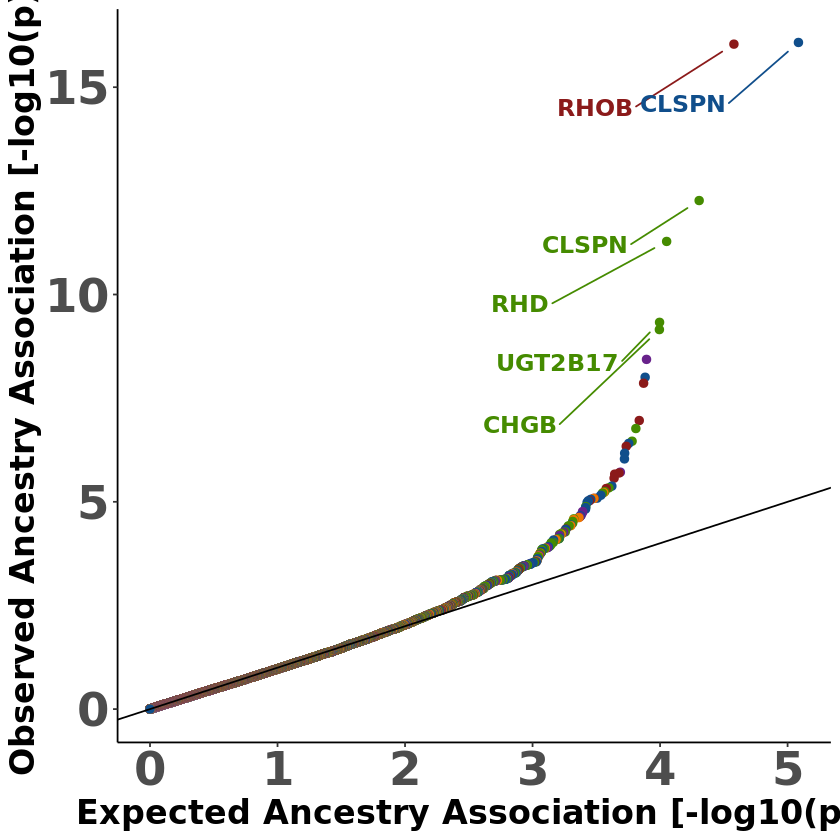

In [53]:
#Generate the qqplot
set.seed(42)
group.colors <- c("African (AFR)" = "darkorange2", "American (AMR)" = "firebrick4", "East Asian (EAS)" ="chartreuse4", "European (EUR)" = "dodgerblue4", "South Asian (SAS)" = "darkorchid4") #Make the color vector


ggplot(melted.df.for.plotting.logistic, aes(x = -log10(random.dist), y = -log10(value), color = Ancestry)) +
geom_point(size = 2) +

theme_bw() +

theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text = element_text(size = 28, face = "bold"),
axis.title = element_text(size = 28, face = "bold")
) +


theme(
legend.position = "none"
) +

geom_abline(intercept = 0, slope = 1) +

xlab("Expected Ancestry Association [-log10(p)]") +
ylab("Observed Ancestry Association [-log10(p)]") +

scale_color_manual(values = group.colors) +

geom_text_repel(aes(label=ifelse(-log10(value) > 9, as.character(gene),'')), box.padding = 1, point.padding = 1, max.overlaps = Inf, nudge_x = -1, nudge_y = -1.5, size = 5, fontface = "bold")




#Put the exported image into the google bucket
paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
ggsave("ancestry_association_logistic.png", dpi = 300, width = 10, height = 10)
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp ancestry_association_logistic.png {workspace_bucket}
"))

# Export a list of all ancestry-associated genes

1) FDR correct the dataset
2) Grab a list of every gene that has a FDR less than 0.05

In [10]:
#Generate the list
ancestry.associated.genes = melted.df.for.plotting.logistic %>%
mutate(value = p.adjust(value, method = "BH", n = length(value))) %>%
filter(0.05 >= value) %>%
pull(gene) %>%
unique() 


#Then export it so that we can use it in other analysis
paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
write.table(ancestry.associated.genes, "ancestry.associated.genes.txt", sep = "\t", col.names = F, row.names = F, quote = F)